In [ ]:
import sys
import time

import numpy as np
from copy import deepcopy

import tensorflow as tf
from attention_gru_cell import AttentionGRUCell

from tensorflow.contrib.cudnn_rnn.python.ops import cudnn_rnn_ops

import babi_input

class Config(object):
    """模型与数据方面的超参数。"""

    batch_size = 100
    embed_size = 81
    hidden_size = 83

    max_epochs = 256
    early_stopping = 20

    dropout = 0.9
    lr = 0.001
    l2 = 0.001

    cap_grads = False
    max_grad_val = 10
    noisy_grads = False

    word2vec_init = False
    embedding_init = np.sqrt(3)

    # set to zero with strong supervision to only train gates
    strong_supervision = False
    beta = 1

    drop_grus = False

    anneal_threshold = 1000
    anneal_by = 1.5

    num_hops = 3
    num_attention_features = 4

    max_allowed_inputs = 130
    num_train = 900

    floatX = np.float32

    babi_id = "1"
    babi_test_id = ""

    train_mode = True

def _add_gradient_noise(t, stddev=1e-3, name=None):
    """按照论文http://arxiv.org/abs/1511.06807中的方法，
    为模型梯度增加噪音提高训练效果（更小的损失函数)。
    
    Args：
        t:梯度（gradient）Tensor。
        stddev: 0.001 被认为是一个适用于memory network的噪音水平。
    Outputs:
        t + gaussian noise.
    """
    with tf.op_scope([t, stddev], name, "add_gradient_noise") as name:
        t = tf.convert_to_tensor(t, name="t")
        gn = tf.random_normal(tf.shape(t), stddev=stddev)
        return tf.add(t, gn, name=name)

# from https://github.com/domluna/memn2n
def _position_encoding(sentence_size, embedding_size):
    """论文"End to End Memory Networks"(http://arxiv.org/pdf/1503.08895v5.pdf)
    第4.1章"Sentence Representation"部分描述的包含单词位置信息的特征提取方法。
    Args:
        sentence_size：句子的长度
        embedding_size: 词向量维度
    Outputs:
        [embedding_size, sentence_size]的tensor，将通过和
        维度为[embedding_size, sentence_size]的句子特征elementwise-multiplication，
        给句子的BOW表示添加位置信息。
    """
    encoding = np.ones((embedding_size, sentence_size), dtype=np.float32)
    ls = sentence_size+1
    le = embedding_size+1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i-1, j-1] = (i - (le-1)/2) * (j - (ls-1)/2)
    encoding = 1 + 4 * encoding / embedding_size / sentence_size
    return np.transpose(encoding)

class DMN_PLUS(object):

    def __init__(self, config):
        self.config = config
        self.variables_to_save = {}
        self.load_data(debug=False)
        self.add_placeholders()
        self.output = self.inference()
        self.pred = self.get_predictions(self.output)
        self.calculate_loss = self.add_loss_op(self.output)
        self.train_step = self.add_training_op(self.calculate_loss)
        self.merged = tf.summary.merge_all()
        self.gru_cell = tf.contrib.rnn.GRUCell(self.config.hidden_size)

    def load_data(self, debug=False):
        """读训练+验证或测试数据。"""
        if self.config.train_mode:
            (self.train, self.valid, self.word_embedding, 
                self.max_q_len, self.max_input_len, self.max_sen_len, 
                self.num_supporting_facts, self.vocab_size) = babi_input.load_babi(
                self.config, split_sentences=True)
            print('training data 样本数: %s' % repr(self.train[0].shape))
        else:
            (self.test, self.word_embedding, 
                self.max_q_len, self.max_input_len, self.max_sen_len, 
                self.num_supporting_facts, self.vocab_size) = babi_input.load_babi(
                self.config, split_sentences=True)
        self.encoding = _position_encoding(self.max_sen_len, self.config.embed_size)


    def add_placeholders(self):
        """声明计算图中的placeholder"""

        self.input_len_placeholder = tf.placeholder(tf.int32, 
            shape=(self.config.batch_size,))
        self.input_placeholder = tf.placeholder(tf.int32, 
            shape=(self.config.batch_size, self.max_input_len, self.max_sen_len))

        self.question_placeholder = tf.placeholder(tf.int32, 
            shape=(self.config.batch_size, self.max_q_len))
        self.question_len_placeholder = tf.placeholder(tf.int32, 
            shape=(self.config.batch_size,))

        self.answer_placeholder = tf.placeholder(tf.int64, 
            shape=(self.config.batch_size,))
        self.rel_label_placeholder = tf.placeholder(tf.int32, 
            shape=(self.config.batch_size, self.num_supporting_facts))

        # 增加dropout
        self.dropout_placeholder = tf.placeholder(tf.float32)
        if self.config.drop_grus:
            self.gru_cell = tf.contrib.rnn.DropoutWrapper(self.gru_cell,
                    input_keep_prob=self.dropout_placeholder,
                    output_keep_prob=self.dropout_placeholder)


    def add_training_op(self, loss):
        """梯度计算和参数更新操作"""
        opt = tf.train.AdamOptimizer(learning_rate=self.config.lr)
        gvs = opt.compute_gradients(loss)

        # optionally cap and noise gradients to regularize
        if self.config.cap_grads:
            gvs = [(tf.clip_by_norm(grad, self.config.max_grad_val), var) for grad, var in gvs]
        if self.config.noisy_grads:
            gvs = [(_add_gradient_noise(grad), var) for grad, var in gvs]

        train_op = opt.apply_gradients(gvs)
        return train_op


    def get_question_representation(self, embeddings):
        """通过词向量(embedding)和GRU encoding得到问题的表示"""
        questions = tf.nn.embedding_lookup(embeddings, self.question_placeholder)

        _, q_vec = tf.nn.dynamic_rnn(self.gru_cell,
                questions,
                dtype=np.float32,
                sequence_length=self.question_len_placeholder
        )

        return q_vec


    def get_input_representation(self, embeddings):
        """通过词向量(embedding)，位置信息（positional encoding）和双向GRU encoding
        计算input的表示"""
        # 单词的词向量表示
        inputs = tf.nn.embedding_lookup(embeddings, self.input_placeholder)

        # 给词向量表示添加位置信息（包含在self.encoding这个tensor里面）
        inputs = tf.reduce_sum(inputs * self.encoding, 2)

        # 双向GRU encoding
        outputs, _ = tf.nn.bidirectional_dynamic_rnn(self.gru_cell,
                self.gru_cell,
                inputs,
                dtype=np.float32,
                sequence_length=self.input_len_placeholder
        )
        
        # 将 forward 和 backward 两个 outputs拼接起来
        # f<-> = f-> + f<-
        fact_vecs = tf.reduce_sum(tf.stack(outputs), axis=0)

        # 添加dropout
        fact_vecs = tf.nn.dropout(fact_vecs, self.dropout_placeholder)

        return fact_vecs


    def get_attention(self, q_vec, prev_memory, fact_vec, reuse):
        """使用问题特征（question vector)和现有记忆（previous memory)计算fact_vec的attention。
          问题和新信息的feature/representation都来自GRU-RNN encoding,即，
          通过get_question_representation（）和get_input_representation（）计算得到。
        
        Args:
            q_vec: [batch_size, hidden_size]， 问题向量
            prev_memory: [batch_size, hidden_size]，当前的记忆向量
            fact_vec: [batch_size, hidden_size]，新的信息向量
        """
        with tf.variable_scope("attention", reuse=reuse):

            # A list of [batch_size, hidden_size] tensors
            features = [fact_vec*q_vec,
                        fact_vec*prev_memory,
                        tf.abs(fact_vec - q_vec),
                        tf.abs(fact_vec - prev_memory)]

            # A NN containing 1 hidden layer with tanh activation function.
            # 1. concatenate to generate input: [batch_size, 4*hidden_size]
            feature_vec = tf.concat(features, 1)

            # 2. NN hidden layer: [batch_size, 4*embed_size]
            attention = tf.layers.dense(feature_vec,
                    self.config.embed_size,
                    activation=tf.nn.tanh)#,
                    #reuse=reuse)

            # 3. [batch_size, 1]
            attention = tf.layers.dense(attention,
                    1,
                    activation=None)#,
                    #reuse=reuse)

        return attention


    def generate_episode(self, memory, q_vec, fact_vecs, hop_index):
        """使用GRU计算attention并从记忆中提取有用的信息

        Args:
            memory: [batch_size, hidden_size]
            q_vec: [batch_size, hidden_size]
            fact_vecs: [batch_size, max_input_len, hidden_size]
        """

        attentions = [tf.squeeze(
            self.get_attention(q_vec, memory, fv, bool(hop_index) or bool(i)), axis=1)
            for i, fv in enumerate(tf.unstack(fact_vecs, axis=1))]

        attentions = tf.transpose(tf.stack(attentions))
        self.attentions.append(attentions)
        attentions = tf.nn.softmax(attentions)
        attentions = tf.expand_dims(attentions, axis=-1)

        reuse = True if hop_index > 0 else False

        # concatenate fact vectors and attentions for input into attGRU
        gru_inputs = tf.concat([fact_vecs, attentions], 2)

        with tf.variable_scope('attention_gru', reuse=reuse):
            _, episode = tf.nn.dynamic_rnn(AttentionGRUCell(self.config.hidden_size),
                    gru_inputs,
                    dtype=np.float32,
                    sequence_length=self.input_len_placeholder
            )

        return episode


    def add_answer_module(self, rnn_output, q_vec):
        """使用 softmax 计算答案"""

        rnn_output = tf.nn.dropout(rnn_output, self.dropout_placeholder)

        output = tf.layers.dense(tf.concat([rnn_output, q_vec], 1),
                self.vocab_size,
                activation=None)

        return output


    def inference(self):
        """在DMN模型中做inference"""

        # set up embedding
        embeddings = tf.Variable(self.word_embedding.astype(np.float32), name="Embedding")

        # input fusion module
        with tf.variable_scope("question", initializer=tf.contrib.layers.xavier_initializer()):
            print('==> get question representation')
            q_vec = self.get_question_representation(embeddings)


        with tf.variable_scope("input", initializer=tf.contrib.layers.xavier_initializer()):
            print('==> get input representation')
            fact_vecs = self.get_input_representation(embeddings)

        # keep track of attentions for possible strong supervision
        self.attentions = []

        # memory module
        with tf.variable_scope("memory", initializer=tf.contrib.layers.xavier_initializer()):
            print('==> build episodic memory')

            # generate n_hops episodes
            prev_memory = q_vec

            for i in range(self.config.num_hops):
                # get a new episode
                print('==> generating episode %d' % i)
                episode = self.generate_episode(prev_memory, q_vec, fact_vecs, i)

                # untied weights for memory update
                with tf.variable_scope("hop_%d" % i):
                    prev_memory = tf.layers.dense(tf.concat([prev_memory, episode, q_vec], 1),
                            self.config.hidden_size,
                            activation=tf.nn.relu)

            output = prev_memory

        # pass memory module output through linear answer module
        with tf.variable_scope("answer", initializer=tf.contrib.layers.xavier_initializer()):
            output = self.add_answer_module(output, q_vec)

        return output


    def get_predictions(self, output):
        preds = tf.nn.softmax(output)
        pred = tf.argmax(preds, 1)
        return pred


    def add_loss_op(self, output):
        """计算损失函数"""
        gate_loss = 0
        # 如果使用supporting facts做监督学习
        if self.config.strong_supervision:
            for i, att in enumerate(self.attentions):
                labels = tf.gather(tf.transpose(self.rel_label_placeholder), 0)
                gate_loss += tf.reduce_sum(
                    tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits=att, labels=labels))

        loss = self.config.beta*tf.reduce_sum(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=output, labels=self.answer_placeholder)) + gate_loss

        # 对于参数（不包含bias部分）添加l2_regularization
        for v in tf.trainable_variables():
            if not 'bias' in v.name.lower():
                loss += self.config.l2*tf.nn.l2_loss(v)

        tf.summary.scalar('loss', loss)

        return loss


    def run_epoch(self, session, data, num_epoch=0, train_writer=None, 
        train_op=None, verbose=2, train=False):
        config = self.config
        dp = config.dropout
        if train_op is None:
            train_op = tf.no_op()
            dp = 1
        print('total samples = %d' % len(data[0]))
        total_steps = len(data[0]) // config.batch_size
        print('total_steps = %d' % total_steps)
        total_loss = []
        accuracy = 0

        # shuffle data
        p = np.random.permutation(len(data[0]))
        qp, ip, ql, il, im, a, r = data
        qp, ip, ql, il, im, a, r = qp[p], ip[p], ql[p], il[p], im[p], a[p], r[p]

        for step in range(total_steps):
            #print('running step %d of totally %d steps\n' % (step, total_steps))
            index = range(step*config.batch_size,(step+1)*config.batch_size)
            feed = {self.question_placeholder: qp[index],
                  self.input_placeholder: ip[index],
                  self.question_len_placeholder: ql[index],
                  self.input_len_placeholder: il[index],
                  self.answer_placeholder: a[index],
                  self.rel_label_placeholder: r[index],
                  self.dropout_placeholder: dp}
            loss, pred, summary, _ = session.run(
              [self.calculate_loss, self.pred, self.merged, train_op], feed_dict=feed)

            if train_writer is not None:
                train_writer.add_summary(summary, num_epoch*total_steps + step)

            answers = a[step*config.batch_size:(step+1)*config.batch_size]
            accuracy += np.sum(pred == answers)/float(len(answers))


            total_loss.append(loss)
            if verbose and step % verbose == 0:
                sys.stdout.write('\r%d / %d: loss = %f\n' % (
                  step, total_steps, np.mean(total_loss)))
                sys.stdout.flush()


        if verbose:
            sys.stdout.write('\r')

        return np.mean(total_loss), accuracy/float(total_steps)




![alt text](figure/dmn-high-level.png)

# 1. Semantic Memory Module
**读入glove参数初始化词向量参数**

![alt text](figure/dmn-details-1.png)

![alt text](figure/glove_embedding.png)

```
 /\
/  \
 ||
```
* 使用`load_glove()`读入glove参数，将glove词向量保存在word2vec（一个`{word: glove_embedding}`dict）中
* 使用`process_word(), create_vector`建立本数据集的词典；对不包含在glove中的词语生成随机的词向量，并添加到word2vec中
* 使用`create_embedding()`整理word2vec，去掉不属于本数据集的词语

# 2. Input and Question Module

考虑一个句子$x = [x_1, x_2, \cdots x_N]$,$x_i$是第i个词语的one-hot vector

1. 词向量的加和（或者平均）作为sentence embedding： $m = \sum_j A x_{j}$
  + $A$ 是embedding parameter matrix
  + $A \cdot x_{j}$ 是查询词向量的操作
2. 加入一些位置信息：$m_{k} = \sum_j l_{k,j} (A_{k,:} \cdot x_{j})$
  + $A_{k,:} \cdot x_{j}$是$x_j$的词向量的第k维度
  + $l_{kj} = (1-j/J) - (k/d)(1-2j/J)$：$x_j$的词向量的第k维度的权重

In [2]:
import numpy as np

def _position_encoding(sentence_size, embedding_size):
    encoding = np.ones((embedding_size, sentence_size), dtype=np.float32)
    ls = sentence_size+1
    le = embedding_size+1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i-1, j-1] = (i - (le-1)/2) * (j - (ls-1)/2)
    encoding = 1 + 4 * encoding / embedding_size / sentence_size
    return np.transpose(encoding)

sentence_size = 15
embedding_size = 64
encoding = _position_encoding(sentence_size, embedding_size)

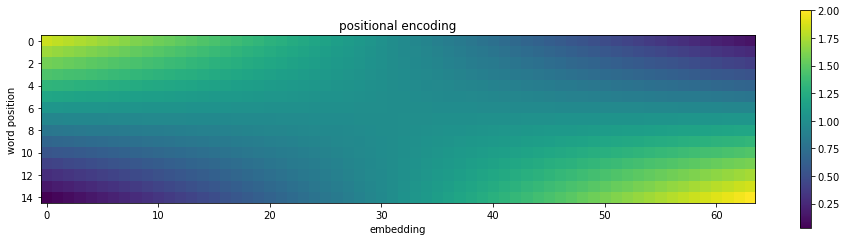

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(111)
ax.set_title('positional encoding')
plt.imshow(encoding)
ax.set_aspect('equal')

plt.xlabel('embedding')
plt.ylabel('word position')
plt.colorbar(orientation='vertical')
plt.show()

![alt text](figure/position_encoding.png)

![alt text](figure/dmn-input-module.png)

![alt text](figure/get_representation.png)

```
 /\
/  \
 ||
```

1. **`qvec`** from **`get_question_representation()`:**
	1. 原始问题句子 -> `question_placeholder`: `[batch_size, max_q_len]` 
    2. 转化为词向量 -> `questions`: `[batch_size, max_q_len, embedding_size = 81]`
	3. 使用RNN讲句子encode成状态向量 -> **`qvec`**: `[batch_size, hidden_size=83]`

2. **`fact_vecs`** from **`get_input_representation`**:
	1. 原始输入句子 -> **`input_placeholder`**: `[batch_size, max_fact_count, max_sen_len]`
	2. 计算句子的positional encoding
        + 转化为词向量 -> **`inputs`**: `[batch_size, max_fact_count, max_sen_len, embedding_size=81]`
		+ 用于positional encoding的参数 -> **`self.encoding`**: `[max_sen_len, embed_size=81]`
		+ 使用positional encoding参数对词向量加权 ->**`inputs`**: `[batch_size, max_fact_count, max_sen_len, embedding_size=81]`
		+ 最终的positional encoding句子特征 -> **`inputs`**: `[batch_size, max_fact_count, embedding_size=81]`
	3. **`outputs`**: 2 `[batch_size, max_input_len, hidden_size = 83]`, (fw and bw outputs)
	4. **`fact_vecs`**: `[batch_size, max_input_len, hidden_size = 83]`

![alt text](figure/dmn-episodic-module.png)

初始化：`prev_memory = q_vec`

**k-hot iteration:**
    1. `prev_memory, q_vec, fact_vecs` --> `espisode`
    2. `prev_memory, q_vec, episode` --> `prev_memory`

![alt text](figure/inference.png)

![alt text](figure/dmn-episodic-module-detail.png)

**`prev_memory, q_vec, fact_vecs` --> `espisode`** 细节过程

1. 从`prev_memory, q_vec, fact_vecs` 出发，使用NN计算每个输入fact的attention
2. 将每个fact和fact的attention weight拼接后输入attentionGRU，更新`espisode`，即图中的**`c`**

![alt text](figure/dmn_episode.png)